# Recurrent Neural Networks

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

## Time series forecasting

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.tail()

,Unadjusted,Seasonally adjusted
Adjustments,,
2016-09-30,45528702,44534797
2016-10-31,44770113,45061618
2016-11-30,46285062,45141762
2016-12-31,50016137,44943929
2017-01-31,37628452,45952103


In [5]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [6]:
split_date = pd.Timestamp('01-01-2011')

In [7]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [8]:
df_scatter(pd.concat([test, train]), title='Train and Test')

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [10]:
train_sc[:4]

array([[ 0.01402033],
       [ 0.        ],
       [ 0.0704258 ],
       [ 0.09531795]])

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [15]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 0s - loss: 0.3462     
Epoch 2/200
239/239 [==============================] - 0s - loss: 0.1625     
Epoch 3/200
239/239 [==============================] - 0s - loss: 0.0899     
Epoch 4/200
239/239 [==============================] - 0s - loss: 0.0535     
Epoch 5/200
239/239 [==============================] - 0s - loss: 0.0397     
Epoch 6/200
239/239 [==============================] - 0s - loss: 0.0351     
Epoch 7/200
239/239 [==============================] - 0s - loss: 0.0324     
Epoch 8/200
239/239 [==============================] - 0s - loss: 0.0299     
Epoch 9/200
239/239 [==============================] - 0s - loss: 0.0273     
Epoch 10/200
239/239 [==============================] - 0s - loss: 0.0248     
Epoch 11/200
239/239 [==============================] - 0s - loss: 0.0223     
Epoch 12/200
239/239 [==============================] - 0s - loss: 0.0201     
Epoch 13/200
239/239 [==============================] - 0s - 

In [16]:
y_pred = model.predict(X_test)

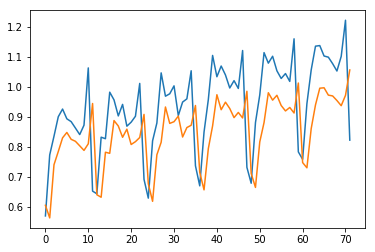

In [19]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [20]:
from keras.layers import LSTM

In [21]:
X_train.shape

(239, 1)

In [22]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape # add an empty dimension to the tensor

(239, 1, 1)

In [23]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [24]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop]) # batch size of 1, training at each data point

Epoch 1/100
239/239 [==============================] - 3s - loss: 0.1733     
Epoch 2/100
239/239 [==============================] - 1s - loss: 0.0634     
Epoch 3/100
239/239 [==============================] - 1s - loss: 0.0486     
Epoch 4/100
239/239 [==============================] - 1s - loss: 0.0410     
Epoch 5/100
239/239 [==============================] - 1s - loss: 0.0344     
Epoch 6/100
239/239 [==============================] - 1s - loss: 0.0276     
Epoch 7/100
239/239 [==============================] - 1s - loss: 0.0225     
Epoch 8/100
239/239 [==============================] - 2s - loss: 0.0179     
Epoch 9/100
239/239 [==============================] - 1s - loss: 0.0146     
Epoch 10/100
239/239 [==============================] - 1s - loss: 0.0128     
Epoch 11/100
239/239 [==============================] - 1s - loss: 0.0116     
Epoch 12/100
239/239 [==============================] - 2s - loss: 0.0110     
Epoch 13/100
239/239 [==============================] - 1s - 

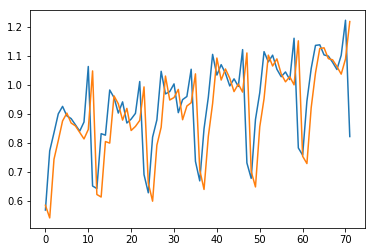

In [27]:
# not much better, just reproduce, we want them to overlap
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows
Rolling window to extract info from tim series. We take a fixed size window and make predictions based on a group of inputs.

In [28]:
train_sc.shape

(240, 1)

In [29]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [30]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [31]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [32]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [33]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [34]:
X_train.shape

(228, 12)

In [35]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [36]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s - loss: 0.0099     
Epoch 2/200
228/228 [==============================] - 0s - loss: 0.0082     
Epoch 3/200
228/228 [==============================] - 0s - loss: 0.0070     
Epoch 4/200
228/228 [==============================] - 0s - loss: 0.0061     
Epoch 5/200
228/228 [==============================] - 0s - loss: 0.0048     
Epoch 6/200
228/228 [==============================] - 0s - loss: 0.0042     
Epoch 7/200
228/228 [==============================] - 0s - loss: 0.0039     
Epoch 8/200
228/228 [==============================] - 0s - loss: 0.0031     
Epoch 9/200
228/228 [==============================] - 0s - loss: 0.0027     
Epoch 10/200
228/228 [==============================] - 0s - loss: 0.0023     
Epoch 11/200
228/228 [==============================] - 0s - loss: 0.0022     
Epoch 12/200
228/228 [==============================] - 0s - loss: 0.0019     
Epoch 13/200
228/228 [==============================] - 0s - 

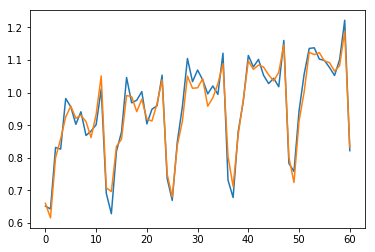

In [38]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [39]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [41]:
print(X_train_t.shape) # 12 coordinates for one input
print(X_train_t[0])

(228, 1, 12)
[[ 0.20091289  0.13173822  0.11139526  0.09230917  0.12617398  0.12395846
   0.13514108  0.16362761  0.09531795  0.0704258   0.          0.01402033]]


In [42]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
# 12 inputs going into 6 nodes and an LSTM has 3 gates
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 3s - loss: 0.1061     
Epoch 2/100
228/228 [==============================] - 1s - loss: 0.0137     
Epoch 3/100
228/228 [==============================] - 1s - loss: 0.0095     
Epoch 4/100
228/228 [==============================] - 1s - loss: 0.0080     
Epoch 5/100
228/228 [==============================] - 1s - loss: 0.0071     
Epoch 6/100
228/228 [==============================] - 1s - loss: 0.0064     
Epoch 7/100
228/228 [==============================] - 1s - loss: 0.0060     
Epoch 8/100
228/228 [==============================] - 1s - loss: 0.0054     
Epoch 9/100
228/228 [==============================] - 1s - loss: 0.0054     
Epoch 10/100
228/228 [==============================] - 1s - loss: 0.0048     
Epoch 11/100
228/228 [==============================] - 1s - loss: 0.0042     
Epoch 12/100
228/228 [==============================] - 1s - loss: 0.0039     
Epoch 13/100
228/228 [==============================] - 1s - 

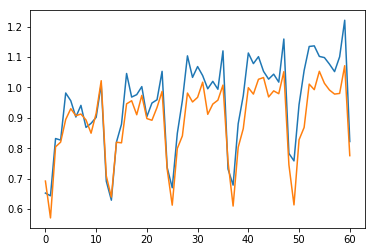

In [46]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [55]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model

In [51]:
X_train = X_train.reshape(228, 12, 1)
X_test = X_test.reshape(61,12, 1)
X_train.shape, X_test.shape

((228, 12, 1), (61, 12, 1))

In [57]:
K.clear_session()

inputs = Input(shape=(12,1))
x = LSTM(6)(inputs)
outputs = Dense(1)(x)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 9s - loss: 0.0973     
Epoch 2/100
228/228 [==============================] - 8s - loss: 0.0127     
Epoch 3/100
228/228 [==============================] - 8s - loss: 0.0098     
Epoch 4/100
228/228 [==============================] - 7s - loss: 0.0092     
Epoch 5/100
228/228 [==============================] - 7s - loss: 0.0089     
Epoch 6/100
228/228 [==============================] - 7s - loss: 0.0087     
Epoch 7/100
228/228 [==============================] - 7s - loss: 0.0084     
Epoch 8/100
228/228 [==============================] - 7s - loss: 0.0083     
Epoch 9/100
228/228 [==============================] - 7s - loss: 0.0084     
Epoch 10/100
228/228 [==============================] - 8s - loss: 0.0084     
Epoch 00009: early stopping


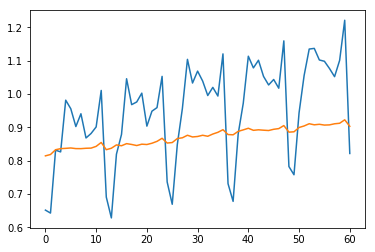

In [60]:
# takes long time to train, would overfit the data, if given enough time
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)

In [11]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Input, Dense, LSTM
from keras.models import Model

In [3]:
(X_train, y_train),(X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = X_train.reshape(X_train.shape[0], 1, -1)
X_test = X_test.reshape(X_test.shape[0], 1, -1)


print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(60000, 1, 784)
(10000, 1, 784)
(60000, 10)
(10000, 10)


In [12]:
inputs = Input(shape=(1, 28*28))
x = LSTM(32)(inputs)
outputs = Dense(10)(x)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 784)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                104576    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 104,906
Trainable params: 104,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train_cat, epochs = 100, validation_split=0.3, shuffle=True, verbose=2)

Train on 42000 samples, validate on 18000 samples
Epoch 1/100
